# QI Pipeline

### This script runs a pipeline to analyze .tsv files coming from JPK data analysis post processing


In [2]:
# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import seaborn as sns
import hyperspy.api as hs
import scipy
from sklearn.decomposition import PCA
import os

## File paths and/or dir paths def


,Filename,Position Index,X Position,Y Position,Baseline Offset [N],Baseline Slope [N/m],Contact Point Offset [m],Slope [N/m],Interpolated Height [m],Ref. Value For Feedback Chan. [N],Height [m],Ref. Value For Feedback Chan. [N].1,Young's Modulus [Pa],Contact Point [m],Baseline [N],Discontinuity Position,Discontinuity Width [m],Adhesion [N],Surface Energy,ResidualRMS [N]
0,qi-data-2022.01.27-14.52.56.754_00000.jpk-qi-s...,0,-0.000004,9.693790e-07,2.437190e-10,-0.000003,0.000007,0.008759,-5.381690e-08,0.0,-1.445630e-07,1.484420e-09,49305.6,6.599410e-09,7.923250e-12,NaN,0.0,0.0,NaN,3.617920e-11
1,qi-data-2022.01.27-14.52.56.754_00001.jpk-qi-s...,1,-0.000004,9.693790e-07,1.037600e-09,-0.000121,0.000007,0.008945,5.686480e-09,0.0,-1.429920e-07,1.484420e-09,43958.2,1.846580e-08,-2.642660e-12,NaN,0.0,0.0,NaN,5.172080e-11
2,qi-data-2022.01.27-14.52.56.754_00002.jpk-qi-s...,2,-0.000004,9.693790e-07,8.753980e-10,-0.000098,0.000007,0.009633,4.876080e-09,0.0,-1.396630e-07,1.484420e-09,49306.4,1.568750e-08,-4.763930e-13,NaN,0.0,0.0,NaN,5.378710e-11
3,qi-data-2022.01.27-14.52.56.754_00003.jpk-qi-s...,3,-0.000004,9.693790e-07,1.101100e-09,-0.000132,0.000007,0.009535,1.691060e-09,0.0,-1.400750e-07,1.484420e-09,50719.5,1.262910e-08,1.198710e-12,NaN,0.0,0.0,NaN,5.005950e-11
4,qi-data-2022.01.27-14.52.56.754_00004.jpk-qi-s...,4,-0.000004,9.693790e-07,1.135950e-09,-0.000137,0.000007,0.009287,-6.758430e-08,0.0,-1.443700e-07,1.484420e-09,49329.1,1.169340e-08,5.679250e-12,NaN,0.0,0.0,NaN,4.854720e-11
5,qi-data-2022.01.27-14.52.56.754_00005.jpk-qi-s...,5,-0.000004,9.693790e-07,1.333250e-09,-0.000166,0.000007,0.008838,-5.690980e-08,0.0,-1.525270e-07,1.484420e-09,46031.5,1.194110e-08,9.202080e-12,NaN,0.0,0.0,NaN,4.885660e-11
6,qi-data-2022.01.27-14.52.56.754_00006.jpk-qi-s...,6,-0.000004,9.693790e-07,1.853350e-09,-0.000242,0.000007,0.008156,-5.352710e-08,0.0,-1.578520e-07,1.484420e-09,38331.7,1.973490e-08,7.736460e-12,NaN,0.0,0.0,NaN,4.676550e-11
7,qi-data-2022.01.27-14.52.56.754_00007.jpk-qi-s...,7,-0.000004,9.693790e-07,2.352230e-09,-0.000315,0.000007,0.007653,-5.390750e-08,0.0,-1.639290e-07,1.484420e-09,32863.1,2.751780e-08,5.026480e-12,NaN,0.0,0.0,NaN,5.485400e-11
8,qi-data-2022.01.27-14.52.56.754_00008.jpk-qi-s...,8,-0.000004,9.693790e-07,1.970560e-09,-0.000257,0.000007,0.007550,-3.848900e-08,0.0,-1.776090e-07,1.484420e-09,27220.4,4.536330e-08,-3.541020e-12,NaN,0.0,0.0,NaN,4.914330e-11
9,qi-data-2022.01.27-14.52.56.754_00009.jpk-qi-s...,9,-0.000004,9.693790e-07,1.399700e-09,-0.000173,0.000007,0.007723,-4.439490e-08,0.0,-1.753880e-07,1.484420e-09,28548.5,4.248000e-08,-1.972570e-12,NaN,0.0,0.0,NaN,4.662770e-11


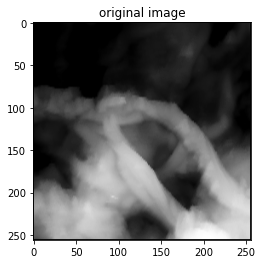

In [3]:
#for single image uncomment here

pathname = '/media/lentilha/TranscendCo/Constanca/afm/testQIanalysis/L15test/processed_images-2022.01.31-13.09.28/pictures/qi-fit-2022.01.27-14.52.56.754.png'
img = cv2.imread(pathname, 0)
plt.imshow(img, cmap='gray'), plt.title('original image')
imgarray_test = np.array(img)
imgarray_test

#for single .tsv file uncomment here

#import datafile from analyzed JPK QI 
#Read jpk .tsv files
datafile = '/media/lentilha/TranscendCo/Constanca/afm/testQIanalysis/L15test/qi-data-2022.01.27-14.52.56.754_processed-2022.01.31-12.52.07.tsv'
df = pd.read_table(datafile)

#check data
df.head(10)
    

In [4]:
#Get columns into vectors and create YM map and height map

#check names of columns in case of error
list(df.columns)

xRange = df['X Position']
yRange = df['Y Position']
youngsModulus = df["Young's Modulus [Pa]"]
height = df["Height [m]"]

#fill NaN values with the next valid value
height = height.fillna(method='ffill')
youngsModulus = youngsModulus.fillna(method='ffill')

logYoungsModulus = np.log10(youngsModulus)

## Process height image

In [5]:
#building the matrix
#my scan matrix in QIs is 256*128
#attention to scanning matrix!!!!!!!
#for QI map the scan direction is:
# 6 7 8
# 3 4 5
# 0 1 2

#scanning dimensions
x = 256
y = 128

#split array corresponding to each row of the matrix
arraysplit_h = np.split(height, y)
#create matrix from split chunks
matrix_h = np.asmatrix(arraysplit_h)
#flip matrix to match scanning direction
matrixfliped_h = np.flip(matrix_h,0)
matrixfliped_h
#sns.heatmap(matrixfliped_h, vmin=-0.0000002, vmax=-0.0000001, cmap=None)
#print(np.median(height))
#print(np.max(height))
#print(np.percentile(height, 1, interpolation = 'midpoint'))
#print(np.percentile(height, 99, interpolation = 'midpoint'))
#print(np.min(height))

matrix([[-1.64649e-07, -1.75290e-07, -1.81747e-07, ..., -1.60981e-07,
         -2.31815e-07, -1.77826e-07],
        [-1.65711e-07, -1.77587e-07, -1.75388e-07, ..., -1.96422e-07,
         -1.72512e-07, -1.70630e-07],
        [-1.76096e-07, -1.74912e-07, -1.76253e-07, ..., -1.76263e-07,
         -1.69994e-07, -1.62353e-07],
        ...,
        [-1.50097e-07, -1.48331e-07, -1.45183e-07, ..., -1.58107e-07,
         -1.59435e-07, -1.54359e-07],
        [-1.53662e-07, -1.39842e-07, -1.40330e-07, ..., -1.64889e-07,
         -1.61884e-07, -1.51003e-07],
        [-1.44563e-07, -1.42992e-07, -1.39663e-07, ..., -1.52191e-07,
         -1.50777e-07, -1.51198e-07]])

Text(0.5, 1.0, 'Rescaled square matrix height (um)')

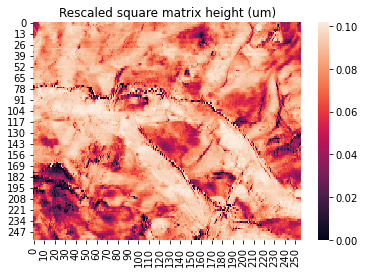

In [17]:
#find min discarding first 1% of data to exclude outliers
#in my case i have this issue bcs i replace missing values with min values
minMatrix = np.percentile(height, 1, interpolation = 'midpoint')

#use only values below 99% percentile
maxMatrix = np.percentile(height, 99, interpolation = 'midpoint')

#replace values below min with new min
newMatrix_h = np.where((matrixfliped_h < minMatrix), minMatrix, matrixfliped_h)
newMatrix_h = np.where((matrixfliped_h > maxMatrix), maxMatrix, matrixfliped_h)

#normalize values to set min to 0
newMatrix_h_norm = newMatrix_h + np.abs(minMatrix)

#divide by um (microns)
newMatrix_h_norm_um = newMatrix_h_norm/0.000001

#look for upper limit for plotting and vis
maxVis = (np.percentile(newMatrix_h_norm_um, 99, interpolation = 'midpoint'))

#plot image to check (uncomment below as needed)
#sns.heatmap(newMatrix_h_norm_um, vmin=0, vmax=maxVis, cmap=None)
#the robust plots percentiles and not minmax
#sns.heatmap(newMatrix_h_norm_um, robust=True, cmap=None)

#create square matrix
newMatrix_h_norm_um_resize = np.repeat(newMatrix_h_norm_um, repeats=2, axis=0)
#plot new matrix to check
sns.heatmap(newMatrix_h_norm_um_resize, vmin=0, vmax=maxVis, cmap=None).set_title('Rescaled square matrix height (um)')

## Roughness analysis from height image

In [7]:
#iterate window trough matrix
#goes through x and then y
#for 256 pixel image, you can split by 64, 32, 16, 8

#Here I define the methods used for the analysis
#Don't touch if nothing is to be changed

def rollingWindowForRoughness(matrix, windowDimension):
    #windowDimension = 2
    a = windowDimension
    b = windowDimension
    i = 0
    j = 0
    raMatrix = []
    rqMatrix = []

    while j < len(matrix):
        i = 0
        b = windowDimension
        tempMeanMatrix = []
        tempSqrtMeanMatrix = []
        while i < len(matrix):
            #print(j,a,i,b)    
            #print(pr[j:a, i:b])
            temp = matrix[j:a, i:b]
            meanHeightWindow = np.mean(temp)
            #print('med:', meanHeightWindow)

            #function to calculate height deviation
            distance = lambda x: np.abs(x-meanHeightWindow)

            #map window array
            distanceMatrix = distance(temp)
            #print('matrix:', distanceMatrix)
            
            meanSqrtDistanceWindow = np.sqrt(np.mean(distanceMatrix)**2)
            tempSqrtMeanMatrix.append(meanSqrtDistanceWindow)

            meanDistanceWindow = np.mean(distanceMatrix)
            tempMeanMatrix.append(meanDistanceWindow)

            b += windowDimension
            i += windowDimension

        #Save calculated Ra and Rq in each window in new matrix
        rqMatrix.append(tempSqrtMeanMatrix)
        raMatrix.append(tempMeanMatrix)
        j += windowDimension
        a += windowDimension
    return raMatrix, rqMatrix

In [8]:
#Tests

#Ra, Rq = rollingWindowForRoughness(newMatrix_h_norm_um_resize, 32)
#print('Ra (um):', Ra)
#print('Rq (um):', Rq)

## Process stiffness image


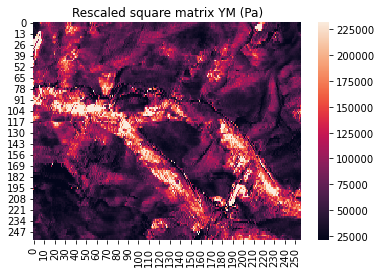

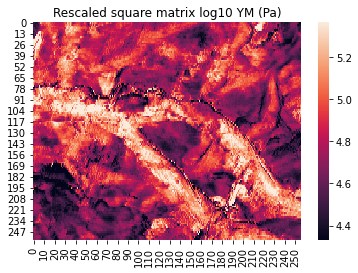

In [9]:
#building the matrix
#my scan matrix in QIs is 256*128
#attention to scanning matrix!!!!!!!
#for QI map the scan direction is:
# 6 7 8
# 3 4 5
# 0 1 2

#scanning dimensions
x = 256
y = 128

#split array corresponding to each row of the matrix
arraysplit_ym = np.split(youngsModulus, y)
arraysplit_ym_log = np.split(logYoungsModulus, y)
#create matrix from split chunks
matrix_ym = np.asmatrix(arraysplit_ym)
matrix_ym_log = np.asmatrix(arraysplit_ym_log)

#flip matrix to match scanning direction
matrixfliped_ym = np.flip(matrix_ym,0)
matrixfliped_ym_log = np.flip(matrix_ym_log,0)

#ATTENTION ATTENTION
#COMMENT THESE 2 LINES OF CODE IF SCAN DIMENSIONS ARE SQUARED
#copy each row to next in order to match the image dimensions of 256*256 pixels
matrixresize_ym = np.repeat(matrixfliped_ym, repeats=2, axis=0)
matrixresize_ym_log = np.repeat(matrixfliped_ym_log, repeats=2, axis=0)

#plot color map to check 
sns.heatmap(matrixresize_ym, robust=True,  cmap=None).set_title('Rescaled square matrix YM (Pa)')
plt.pause(0.05)
plt.show()

sns.heatmap(matrixresize_ym_log, robust=True, cmap=None).set_title('Rescaled square matrix log10 YM (Pa)')
plt.pause(0.05)
plt.show()


## Statistics with rolling window through stiffness map

In [10]:
#Defining the method to run statistics on rolling window
# iterate window trough matrix
#goes through x and then y

def rollingWindowForStats(matrix, windowDimension):
    #windowDimension = 2
    a = windowDimension
    b = windowDimension
    i = 0
    j = 0
    meanMatrix = []
    medianMatrix = []

    while j < len(matrix):
        i = 0
        b = windowDimension
        tempMean = []
        tempMedian = []
        while i < len(matrix):
            print(j,a,i,b)    
            #print(pr[j:a, i:b])
            temp = matrix[j:a, i:b]
            #sns.heatmap(temp,vmin=None, vmax=150000, cmap=None)
            #plt.pause(0.05)
            #plt.show()
            
            #plot histogram distribution of stiffness per matrix
            #plt.hist(temp)
            #plt.pause(0.05)
            #plt.show()
            
            #calculate mean and median of each segment
            tempAvg = np.average(temp)
            tempMed = np.median(temp)
            tempMean.append(tempAvg)
            tempMedian.append(tempMed)
            #print(np.average(temp))
            #mean_temp.append(np.mean(temp))
            b += windowDimension
            i += windowDimension
        meanMatrix.append(tempMean)
        medianMatrix.append(tempMedian)
        j += windowDimension
        a += windowDimension
    return meanMatrix, medianMatrix

In [11]:
#Define size of window
#rollingWindowForStats(matrixresize_ym, 32)

## FFT Analysis and methods

In [12]:
#iterate window trough matrix
#goes through x and then y
#for 256 pixel image, you can split by 64, 32, 16, 8

def rollingWindowForLocalFft(img, windowDimension):
    #windowDimension = 2
    imgarray = np.array(img)
    a = windowDimension
    b = windowDimension
    i = 0
    j = 0
    fftMatrix = []
    imgMatrix = []
    #plt.imshow(img)
    #plt.show()
    testWindows = []

    while j < len(imgarray):
        i = 0
        b = windowDimension
        tempFftCol = []
        tempCol = []
        while i < len(imgarray):
            #print(j,a,i,b)    
            #print(pr[j:a, i:b])
            temp = imgarray[j:a, i:b]
            #subtract average
            temp_avg = np.mean(temp)
            temp = temp - temp_avg

            temp = scipy.signal.detrend(temp) 
            
            #plot each segment of image
            #plt.imshow(temp)
            #plt.pause(0.05)
            #plt.show()

            #apply hanning window
            #hanningf = np.hanning(windowDimension)
            #hanningWindow2d = np.sqrt(np.outer(hanningf, hanningf))
            
            #apply local fft in each segment
            tempFft = np.fft.fft2(temp)
            centeredTempFft = np.fft.fftshift(tempFft)
            tempFftConv = np.log(1+np.abs(centeredTempFft))

            #This is test for fft + scikit-learn bs
            #imdataWfft = np.fft.fftshift(np.abs(np.fft.fft2(temp)**2))
            #imdataWfft = np.log(np.abs(imdataWfft))
            #imWindowFFT = hs.signals.Signal2D(imdataWfft)
            #imWindowFFT.plot(cmap='plasma', axes_ticks=False, scalebar=False, axes_off=True) #plot 4D local FFT data
            #imWindowFFT.decomposition()
            #imWindowFFT.plot_explained_variance_ratio(n=30, xaxis_type='number') #plot PCA Scree Plot
            #tempFftConvtest = hs.signals.Signal2D(tempFftConv)
            #tempFftConvtest.decomposition()

            #plot histogram and local fft of each segment
            #plt.hist(tempFftConv)
            #plt.imshow(tempFftConv)
            #plt.pause(0.05)
            #plt.show()

            tempCol.append(temp)
            tempFftCol.append(tempFftConv)
            b += windowDimension
            i += windowDimension
        
        #save each row scanned in the new matrix
        imgMatrix.append(tempCol)
        fftMatrix.append(tempFftCol)
        j += windowDimension
        a += windowDimension
    
    return fftMatrix, imgMatrix

## Run here all methods to perform analysis
### Don't forget to check if the file paths are ok
### Check if window dimensions are compatible with matrix dimensions
### for example, a 256 pixel image, you can split by 64, 32, 16, 8

In [13]:
#Define size of window
#a 256 pixel image, you can split by 64, 32, 16, 8

ws = 32
#stats = []
stats = rollingWindowForStats(matrixresize_ym, ws)

Ra, Rq = rollingWindowForRoughness(newMatrix_h_norm_um_resize, 32)
print('Ra (um):', Ra)
print('Rq (um):', Rq)

0 32 0 32
0 32 32 64
0 32 64 96
0 32 96 128
0 32 128 160
0 32 160 192
0 32 192 224
0 32 224 256
32 64 0 32
32 64 32 64
32 64 64 96
32 64 96 128
32 64 128 160
32 64 160 192
32 64 192 224
32 64 224 256
64 96 0 32
64 96 32 64
64 96 64 96
64 96 96 128
64 96 128 160
64 96 160 192
64 96 192 224
64 96 224 256
96 128 0 32
96 128 32 64
96 128 64 96
96 128 96 128
96 128 128 160
96 128 160 192
96 128 192 224
96 128 224 256
128 160 0 32
128 160 32 64
128 160 64 96
128 160 96 128
128 160 128 160
128 160 160 192
128 160 192 224
128 160 224 256
160 192 0 32
160 192 32 64
160 192 64 96
160 192 96 128
160 192 128 160
160 192 160 192
160 192 192 224
160 192 224 256
192 224 0 32
192 224 32 64
192 224 64 96
192 224 96 128
192 224 128 160
192 224 160 192
192 224 192 224
192 224 224 256
224 256 0 32
224 256 32 64
224 256 64 96
224 256 96 128
224 256 128 160
224 256 160 192
224 256 192 224
224 256 224 256
Ra (um): [[0.008749255622863774, 0.00688386756134033, 0.005486313064575197, 0.0065438553009033226, 0.014

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=RPCA
  output_dimension=20
  centre=None
[########################################] | 100% Completed |  0.1s


[########################################] | 100% Completed |  0.1s
Blind source separation info:
  number_of_components=13
  algorithm=sklearn_fastica
  diff_order=1
  reverse_component_criterion=factors
  whiten_method=PCA
scikit-learn estimator:
FastICA(tol=1e-10, whiten=False)


<Signal2D, title: , dimensions: (32, 32|8, 8)>

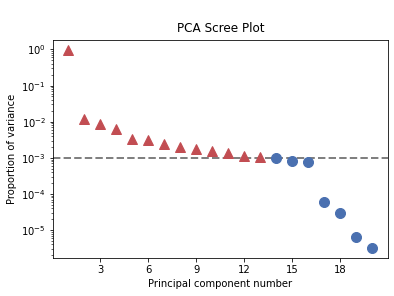

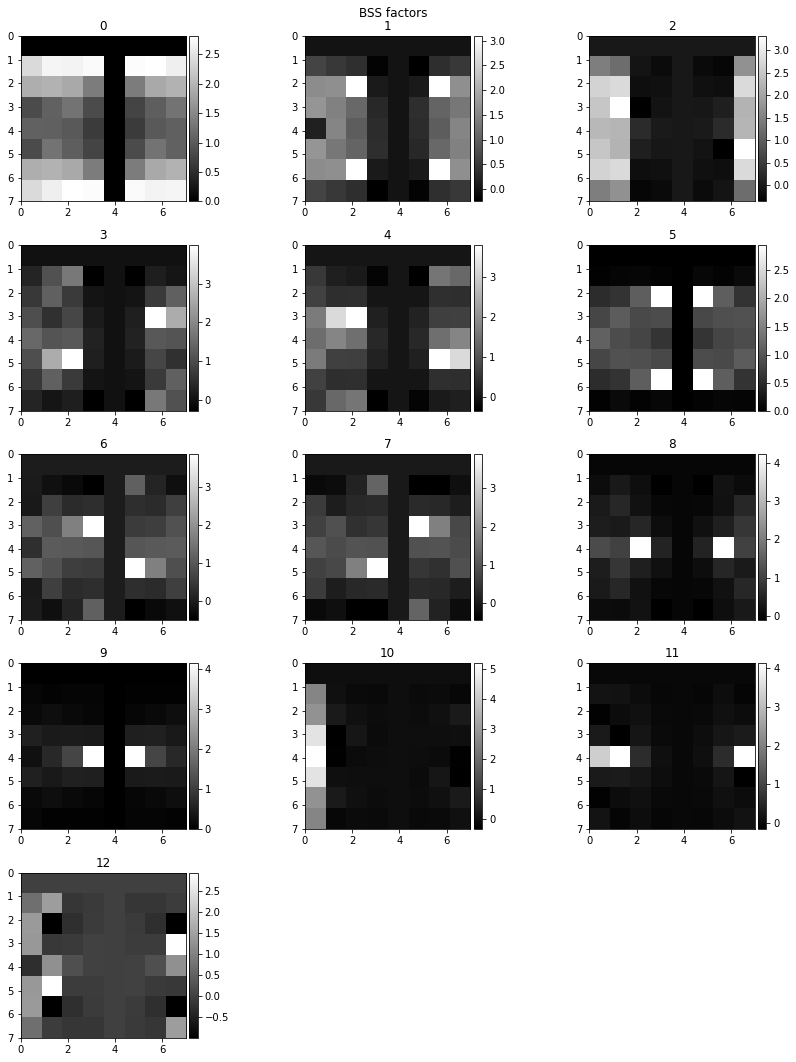

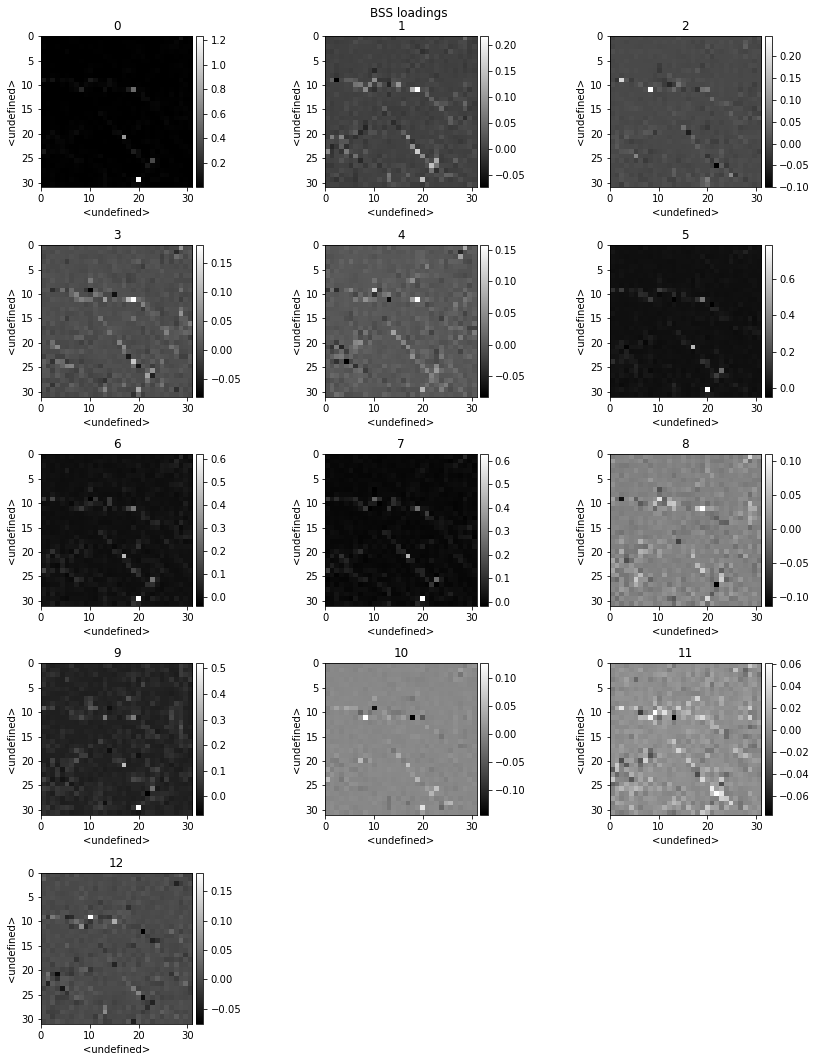

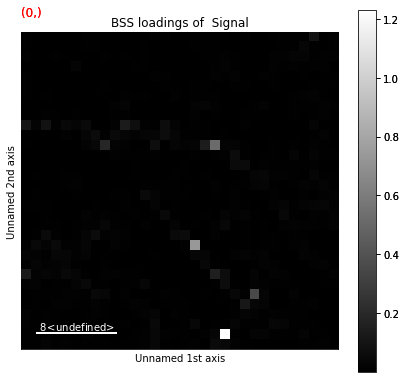

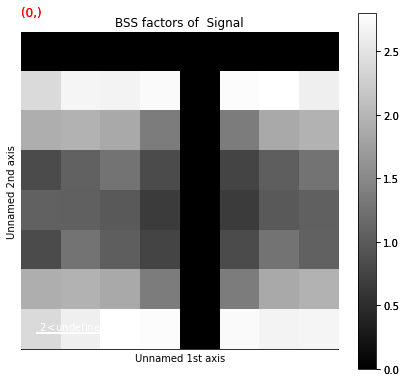

In [19]:
X, I = rollingWindowForLocalFft(newMatrix_h_norm_um_resize, 8)
#X, I = rollingWindowForLocalFft(matrixresize_ym_log, 16)


pcaX = hs.signals.Signal2D(X)
pcaX.decomposition(algorithm='RPCA', output_dimension=20)
pcaX.plot_explained_variance_ratio(n=None, threshold=0.001, xaxis_type='number') #plot PCA Scree Plot
pcaX.blind_source_separation(13)
pcaX.plot_bss_factors()
pcaX.plot_bss_loadings()
pcaX.plot_bss_results()
pcaX

/home/lentilha/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/lentilha/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=23
  centre=None
scikit-learn estimator:
NMF(n_components=23)


[<AxesSubplot:title={'center':' (0,)'}>,
 <AxesSubplot:title={'center':' (1,)'}>,
 <AxesSubplot:title={'center':' (2,)'}>,
 <AxesSubplot:title={'center':' (3,)'}>,
 <AxesSubplot:title={'center':' (4,)'}>,
 <AxesSubplot:title={'center':' (5,)'}>,
 <AxesSubplot:title={'center':' (6,)'}>,
 <AxesSubplot:title={'center':' (7,)'}>,
 <AxesSubplot:title={'center':' (8,)'}>,
 <AxesSubplot:title={'center':' (9,)'}>,
 <AxesSubplot:title={'center':' (10,)'}>,
 <AxesSubplot:title={'center':' (11,)'}>,
 <AxesSubplot:title={'center':' (12,)'}>,
 <AxesSubplot:title={'center':' (13,)'}>,
 <AxesSubplot:title={'center':' (14,)'}>,
 <AxesSubplot:title={'center':' (15,)'}>,
 <AxesSubplot:title={'center':' (16,)'}>,
 <AxesSubplot:title={'center':' (17,)'}>,
 <AxesSubplot:title={'center':' (18,)'}>,
 <AxesSubplot:title={'center':' (19,)'}>,
 <AxesSubplot:title={'center':' (20,)'}>,
 <AxesSubplot:title={'center':' (21,)'}>,
 <AxesSubplot:title={'center':' (22,)'}>]

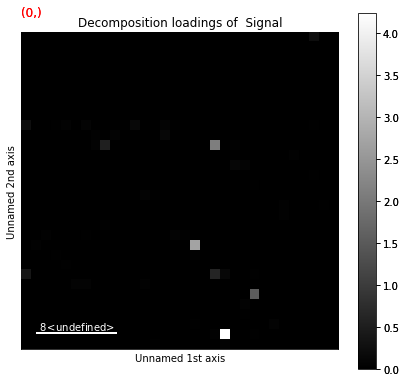

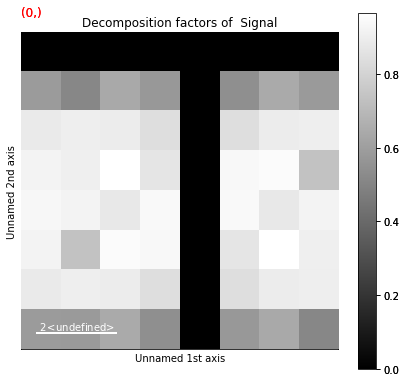

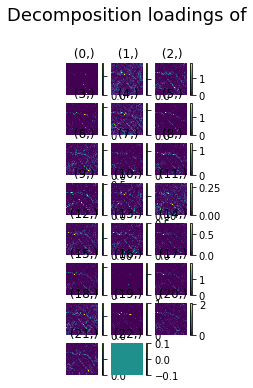

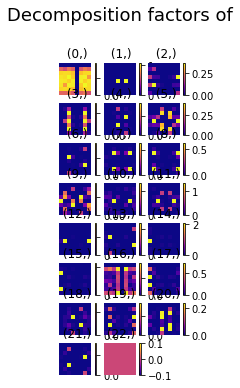

In [15]:
#output dimensions come from nr of components of the scree plot
pcaX.decomposition(algorithm="NMF", output_dimension=23)
pcaX.plot_decomposition_results()
#elementsize = 32
#elementsize*img.axes_manager[0].scale # if properly calibration read from image file
loadingsS = pcaX.get_decomposition_loadings()
hs.plot.plot_images(loadingsS,cmap='viridis', scalebar=None, axes_decor='off')
factorsS =  pcaX.get_decomposition_factors()
hs.plot.plot_images(factorsS,cmap='plasma', scalebar=None, axes_decor='off')

In [16]:
#trial for automation by folder